# **ML PROJECT - WHY SO HARSH?**

## Team Members:
## Anshul Jindal - IMT2020039 <br>
## Shreeya Venneti - IMT2020535

## Mounting the Google Drive

Train and Test data have been placed in Google Drive. This reduces the time taken to upload test and train data onto local runtime. 
<br>

Both Test.csv and Train.csv are placed in "Colab Notebooks" directory in google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mkdir Results

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import  Counter
import seaborn as sns

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install contractions
import contractions
import string
import regex as re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from textblob import TextBlob
import pickle
from sklearn.metrics import accuracy_score, f1_score 

from nltk.corpus import words
nltk.download('words')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 5.2 MB/s 
     |████████████████████████████████| 287 kB 33.5 MB/s 


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


##Reading the Train and Test Data Files:

In [4]:
# These all columns are need to be read. NO UNAMED COLUMNS are to be read.
col_list_train = ["id", "text", "harsh", "extremely_harsh", "vulgar", "threatening", "disrespect", "targeted_hate"]

# low_memory = false to avoid DTypy warning while reading pandas dataframe
# Link: https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv", usecols=col_list_train, low_memory=False)

train_df.head()

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,a8be7c5d4527adbbf15f,""", 6 December 2007 (UTC)\nI am interested, not...",0,0,0,0,0,0
1,0b7ca73f388222aad64d,I added about three missing parameters to temp...,0,0,0,0,0,0
2,db934381501872ba6f38,SANDBOX?? \n\nI DID YOUR MADRE DID IN THE SANDBOX,1,0,0,0,0,0
3,228015c4a87c4b1f09a7,"why good sir? Why? \n\nYou, sir, obviously do ...",1,0,1,1,1,0
4,b18f26cfa1408b52e949,"""\n\n Source \n\nIncase I forget, or someone e...",0,0,0,0,0,0


In [5]:
col_list_test = ["id", "text"]

test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv", usecols=col_list_test, low_memory=False)

test_df.head()

,id,text
0,e0ae9d9474a5689a5791,in an interview before his execution
1,b64a191301cad4f11287,He knew what he was doing. The below posts are...
2,5e1953d9ae04bdc66408,Zzzzzzz... youre a real bore. Now go bore some...
3,23128f98196c8e8f7b90,"""\n\nYet, it remains confusion because the 910..."
4,2d3f1254f71472bf2b78,I was referring to them losing interest in van...


Copying the Test_df into another variable so that we can process that variable later without modifying original test_df

In [6]:
Final_df = test_df.copy()

## Basic Checks on the Data

In [7]:
train_df.isna().sum()

id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
dtype: int64

In [8]:
(train_df == "?").sum()

id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
dtype: int64

Thus, We don't have any NAN values present in our dataset.

# **TRAIN AND TEST SPLIT**

Now we will split our Training dataset only into 2 parts: Training Set and Test Set. This is to just check the Accuracy or F1 Score for our Models. <br>

For creating final submission, this part is not needed.

In [9]:
# from sklearn.model_selection import train_test_split 

# train_df, test_df = train_test_split(train_df, train_size=0.8)

In [10]:
# Final_df = test_df.copy()

## **Manual Cleaning** of the Text

In [11]:
def Manual_cleanText(string):

 string = re.sub(":\)", " smiling", string)
 string = re.sub("\(:", " smiling", string)
 string = re.sub(":-\)", " smiling", string)
 string = re.sub("\(-:", " smiling", string)
 string = re.sub(":-\)\)", " smiling", string)
 string = re.sub("\(\(-:", " smiling", string)

 string = re.sub(":\(", " sad", string)
 string = re.sub("\):", " sad", string)
 string = re.sub(":-\(", " sad", string)
 string = re.sub("\)-:", " sad", string)
 string = re.sub(":-\(\(", " sad", string)
 string = re.sub("\)\)-:", " sad", string)

 string = re.sub(":'\)", " sad", string)
 string = re.sub(":'\)\)", " sad", string)

 return string

In [12]:
def Manual_cleanDataset(dataframe, column_name):
  
  dataframe[column_name] = dataframe[column_name].apply(lambda x:Manual_cleanText(x))

  return dataframe

In [13]:
# # MANUAL CLEANING
# train_df = Manual_cleanDataset(train_df, "text")
# test_df = Manual_cleanDataset(test_df, "text")

# **CLEANING UP THE TEXT**

Before proceeding towards EDA and Prepprocessing, lets clean up the text data. <br> Cleaning will include removal of all the words, characters etc. that won't be helpful in predicting the labels.

## **One Shot** Cleanups

In this, we perform the following actions:


*   Remove all the URL's from the text

*   Remove all Punctuation Marks and Special Characters except ?, !, # and @.

*   Lower the text
*   Remove the numeric data.


In [14]:
def One_Shot_Cleanups(dataframe, column_name):

  text_list = dataframe[column_name].tolist()

  for i in range(len(text_list)):

    # Removing Punctuation mark and spcial characters
    # Remove all the numeric data
    # Remove URL
    text_list[i] = re.sub('[^a-zA-Z?!\*]+', ' ', text_list[i])
    # text_list[i] = re.sub('[^a-zA-Z?!#@\*]+', ' ', text_list[i])

    # # Lowering the text except the words which are all capitals
    # text_list[i] = text_list[i].split()
    # for j in range(len(text_list[i])):
    #   if text_list[i][j] != text_list[i][j].upper():
    #     text_list[i][j] = text_list[i][j].lower()
    # text_list[i] = ' '.join(text_list[i])

  
  dataframe[column_name] = text_list

  return dataframe

In [15]:
# REMOVE PUNCTUATION, NUMBERS and SPECIAL CHARACTERS
train_df = One_Shot_Cleanups(train_df, "text")
test_df = One_Shot_Cleanups(test_df, "text")

In [16]:
test_df.to_csv('Check_RE.csv', index = False)

# **EXPLORATORY DATA ANALYSIS**

Let's Analysis our dataset so that we can get some intutuion of how our results gonna be like. This will give us insight into planning our models as well as what type of preprocessing we require.

## PIE - CHART Showing Category Distribution

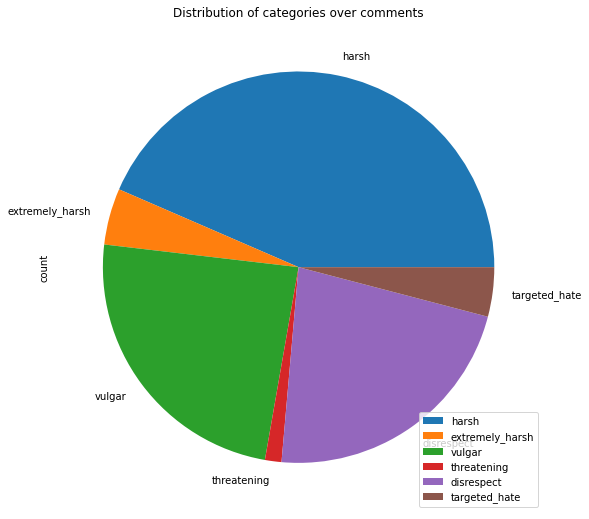

In [17]:
categories = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

category_counts = train_df[categories].sum()

category_count_list = list(category_counts)

category_freq_df = pd.DataFrame({"category": categories, "count": category_count_list})

category_freq_df.plot.pie(y = "count", figsize = (9,9), legend = True, title = "Distribution of categories over comments", labels = categories)

plt.legend(loc="lower right")

**INFERENCE** - Mostly comments are either 'harsh', 'vulgur' or 'disrespectful'. Very less comments are 'threatening'. <br>

Hence we can expect same distribution in the test data also.

## Printing the Counts

In [18]:
print(category_freq_df)

          category  count
0            harsh   8559
1  extremely_harsh    917
2           vulgar   4742
3      threatening    268
4       disrespect   4392
5    targeted_hate    802


## CORRELATION MATRIX

Here we are checking Co-relation between the labels. it will help us get an idea how our output labels should be.

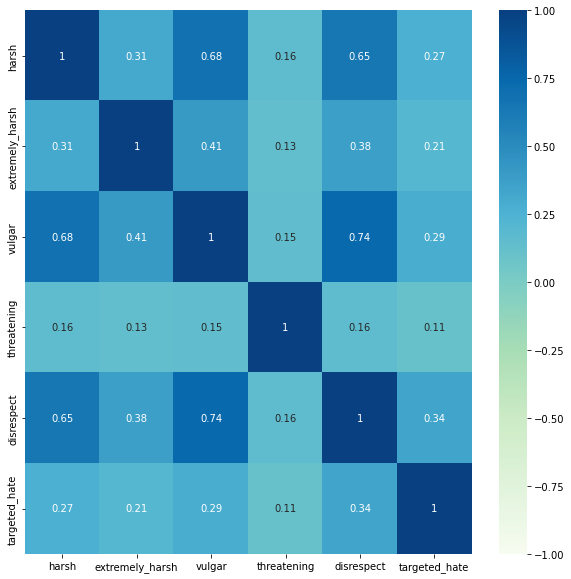

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df[categories].corr(), vmin=-1, cmap="GnBu", annot=True)

**INFERENCE** - Label Columns are not much Corelated to each other. Hence we can't link one to another in any of the data models we will train.

## WORD LEVEL ANALYSIS

Let's find the length of every word in the comments by making a dataframe of words containing the following columns:


*   Word
*   Frequency
*   Word_Length



In [20]:
def create_word_dataframe(series):

  words_list = []

  for paragraph in series:
    words_list.append(nltk.word_tokenize(paragraph))

  flattened_list = [j for sub in words_list for j in sub]

  words_list = flattened_list

  word_dictionary = {}

  for word in words_list:
    word_dictionary[word] = 0

  for word in words_list:
    word_dictionary[word] += 1

  df_word = pd.DataFrame(word_dictionary.items(),columns=['word','frequency'])

  df_word['word_length']= df_word['word'].map(lambda x: len(x))

  df_word = df_word.sort_values('frequency',ascending=False).reset_index(drop=True)

  return df_word

In [21]:
word_dataframe = create_word_dataframe(train_df["text"])

word_dataframe.head(10)

,word,frequency,word_length
0,the,252701,3
1,to,163886,2
2,I,125803,1
3,of,124577,2
4,and,119782,3
5,a,113982,1
6,you,101617,3
7,is,94679,2
8,that,85711,4
9,in,75615,2


**HISTOGRAM PLOTS** - Let us find the word length distribution by plotting histograms from the dataframe obtained. <br>

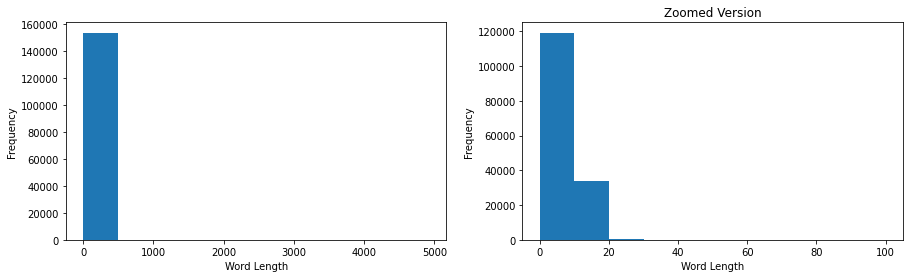

In [22]:
figure, axis = plt.subplots(1, 2, figsize=(15, 4))

axis[0].hist(word_dataframe['word_length'])
axis[0].set_xlabel('Word Length')
axis[0].set_ylabel('Frequency')


axis[1].hist(word_dataframe['word_length'], range = [0, 100])
axis[1].set_title("Zoomed Version")
axis[1].set_xlabel('Word Length')
axis[1].set_ylabel('Frequency')
print()

**OBSERVATION:**



*   We have words having word lengths ranging from 0 to 5000 (approx).
*   There are very few words having word length greater than 40.

**INFERENCE:**


*   There is very less probability that words of length greater than 40 would make any sense.<br>
Further, will they have any contribution towards sentiment analysis, chances are very very slim.
*   Hence, we can remove all the words of length greater than 40.
*   This will speed up the Lemmatization process also.








Lets check out the word having maximum length.

In [23]:
word_dataframe[word_dataframe['word_length'] == max(word_dataframe['word_length'])]

,word,frequency,word_length
141965,hyyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyu...,1,4926


Clearly, this doesn't make any sense.

**REMOVING THE WORDS**

Let's remove the words of length greater than 40

In [24]:
def remove_long_words(dataframe, column_name):

  text_list = dataframe[column_name].tolist()

  for i in range(len(text_list)):
    text_list[i] = re.sub(r'\W*\b\w{40,5000}\b', '',text_list[i])

  dataframe[column_name] = text_list

  return dataframe

In [25]:
# # REMOVE LONG WORDS
# train_df = remove_long_words(train_df, "text")
# test_df = remove_long_words(test_df, "text")

Now let's plot the Histogram again

In [26]:
word_dataframe_new = create_word_dataframe(train_df["text"])

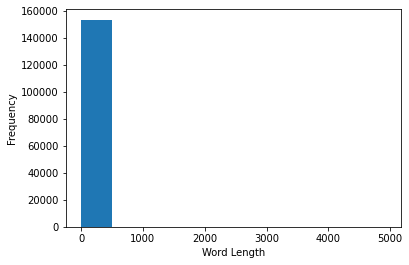

In [27]:
plt.hist(word_dataframe_new['word_length'])
plt.xlabel("Word Length")
plt.ylabel("Frequency")

print()
plt.show()

Now we have all words whose length ranges from 0 to 40 only.

## SENTIMENT ANALYSIS
Let us now try to find the general sentiment of the commenters by plotting a histogram showing the polarity and subjectivity levels of the comments.

##POLARITY <br>
* Polarity refers to **strength of an opinion**. It can be positive, negative or neutral, with neutral meaning no sentiment expressed. 
* Polarity values lie in the range [-1,1] with [-1,0) implying negative sentiment, 0 implying neutral and (0,1] implying positive sentiment.

This is a method that uses TextBlob library to find the polarity of every comment when the "text" column of the dataframe is passed to it. It creates and returns a new dataframe with the columns being: comments and their polarity values.

In [28]:
def find_polarity(series):

  sentiment_objects = [TextBlob(comment) for comment in series]

  sentiment_values = [[comment.sentiment.polarity, str(comment)] for comment in sentiment_objects]

  sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "comment"])

  return sentiment_df

Calling the method to obtain the dataframe with polarity values

In [29]:
polarity_df = find_polarity(train_df["text"])

Plotting a histogram to find the polarity distribution over comments

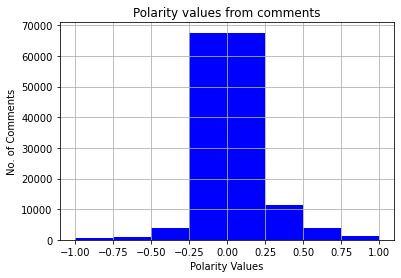

In [30]:
polarity_df.hist(bins = [-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],color = "blue")

plt.title("Polarity values from comments")
plt.xlabel("Polarity Values")
plt.ylabel("No. of Comments")

print()
plt.show()

**INFERENCE:** <br>
* The above histogram shows that most commenters (about 80,000) have a neutral sentiment polarity or no sentiment.
* The rest of the commenters about 9,000 have made polar comments, which is the subject of our analysis.
* Thus we can expect similar results upon fitting our classification model.

## SUBJECTIVITY <br>
* **Subjectivity** in text indicates presence of the writer's own feelings, experiences or emotions.
* This is in contrast to objective text which is mostly factual and not opinion based.
* Subjectivity indicates extent or degree of involvement of the person in the object.
* Subjectivity also lies in the range [-1,1] and thus takes both positive and negative values

This is a method that uses TextBlob library to find the subjectivity of every comment when the "text" column of the dataframe is passed to it. It creates and returns a new dataframe with the columns being: comments and their subjectivity values.

In [31]:
def find_subjectivity(series):

  sentiment_objects = [TextBlob(comment) for comment in series]

  sentiment_values = [[comment.sentiment.subjectivity, str(comment)] for comment in sentiment_objects]

  sentiment_df = pd.DataFrame(sentiment_values, columns=["subjectivity", "comment"])

  return sentiment_df

Calling the method to obtain the dataframe with subjectivity values

In [32]:
subjectivity_df = find_subjectivity(train_df["text"])

Plotting a histogram to find the subjectivity distribution over comments

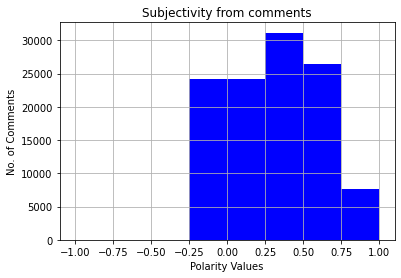

In [33]:
subjectivity_df.hist(bins = [-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],color = "blue")

plt.title("Subjectivity from comments")
plt.xlabel("Polarity Values")
plt.ylabel("No. of Comments")

plt.show()

**INFERENCE:** <br>
* The above histogram shows that the comments are highly biased towards subjectivity, i.e every comment is subjective and is purely based on the commenter's opinion & experience and is not objective/fact-based. This also indicates presence of strong emotions/feelings of the commenter.

## WORD CLOUD

Let's create a word cloud to get a visual representation of the top frequently used words by the commenters. The larger the size of the word in the word cloud, the higher the frequency of usage by the commenter.

In [34]:
def show_overall_word_cloud(series):

  text = " ".join(i for i in series)
  wordcloud = WordCloud(stopwords = stop_words, background_color = "white").generate(text)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

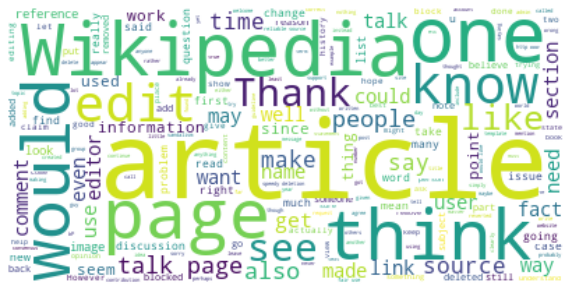

In [35]:
show_overall_word_cloud(train_df["text"])

**INFERENCE** - The words "one", "article", "page", "think", etc seem to used very frequently. Some of these words are of no use in case of sentiment analysis. <br>
For example the word "article" can't contribute to sentiment analysis. Hence, we can manually remove these words for out text data.

Let us find the top 15 commonly used words in the text (words which aren't stopwords, as they will be removed)

In [36]:
stop_words = stopwords.words('english')

def find_word_frequencies(column):
    
    split_column = column.str.split()
    text_list = split_column.tolist()

    word_list = [word for i in text_list for word in i]

    counter_object = Counter(word_list)

    most_common_object = counter_object.most_common()

    x_coordinate = []
    y_coordinate = []

    for word_name, word_frequency in most_common_object[:100]:
    
        if (word_name not in set(stop_words)):
            y_coordinate.append(word_name)
            x_coordinate.append(word_frequency)
            
    sns.barplot(x = x_coordinate, y = y_coordinate)

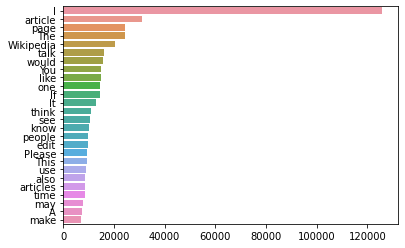

In [37]:
find_word_frequencies(train_df["text"])

The above barplot shows that the words "article", "page", "would", "one", "wikipedia", "see", "know", "also", "make", "people", "may", "edit", "source", "use", "get", "need", "even", "time", "want", "say", "could" and "user" are used quite frequently by the commenters. These most common words do not play role in sentiment analyis, thus we can remove them in the following data clean up section.

## **Expanding** the Text

Contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe.

In [38]:
def Expand_text(string):

 string = contractions.fix(string) 

 return string

In [39]:
def Expand_Dataset(dataframe, column_name):
  
  dataframe[column_name] = dataframe[column_name].apply(Expand_text)

  return dataframe

In [40]:
# # Expanding Text
# train_df = Expand_Dataset(train_df, "text")
# test_df = Expand_Dataset(test_df, "text")

# **PREPROCESSING OF THE DATA**

After done with analysis and cleaning of our text data, let's proceed towards preprocessing required to fit our ML Models.<br>

**NOTE** - Cleaning of the text which we did above also constitutes as preprocessing.

## **Tokenization** and **Lemmatization** of Text

In [41]:
# Declaring the Objects of the classes present in nltk library

word_lemmatizer = WordNetLemmatizer()
# tweet_tokenizer = nltk.tokenize.TweetTokenizer()
word_tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [42]:
def tokenize_and_lemmatize_text(text):
    return [word_lemmatizer.lemmatize(word) for word in word_tokenizer.tokenize(text)]  # if word not in set(stop_words)]

In [43]:
def lemmatize_dataset(dataframe, column_name):

  # Some text may be just numbers or any other data type. Hence we first convert every text to string format.
  dataframe[column_name] = dataframe[column_name].apply(str)

  text = dataframe[column_name]

  text = text.apply(tokenize_and_lemmatize_text) 

  text = text.apply(lambda x: ' '.join(([word for word in x ])))  #if word not in set(stop_words)])))

  dataframe[column_name] = text

  return dataframe

In [44]:
# LEMMATIZATION
train_df = lemmatize_dataset(train_df,"text")
test_df = lemmatize_dataset(test_df,"text")

## Category - Wise Word Clouds

Now we will see which words are most occuring in the sentences for each label category.

In [45]:
def show_word_cloud(dataframe, text_column, category_name):

  text = ""
  for i in range(dataframe.shape[0]):
    if (dataframe.loc[i].at[category_name] == 1):
      text = text + dataframe.loc[i].at[text_column]

  unique_words = set(text.split(' '))
  text = ' '.join(unique_words)

  wordcloud = WordCloud(stopwords = stop_words, background_color = "white").generate(text)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [46]:
# show_word_cloud(train_df, "text", "harsh")

In [47]:
# harsh_words_list = ['fuck', 'FUCK', 'fucking', 'FUCKING' "F**K", 'F*CK', 'FU*K', 'F*CKING', 'FU*CKING', 'F**KING', 'bitch', 'f**k', 'f**king', 'f*ck','fu*k', 'fu*cking' 'f*cking', 'f***king', 'asshole']

In [48]:
# show_word_cloud(train_df, "text", "extremely_harsh")

In [49]:
# extremely_harsh_words_list = ['bitch', 'cunt', 'asshole']

In [50]:
# show_word_cloud(train_df, "text", "vulgar")

In [51]:
# vulgar_words_list = ['fuck', 'bitch' 'f**k', 'f**king', 'f*ck','fu*k', 'fu*cking']

In [52]:
# show_word_cloud(train_df, "text", "threatening")

In [53]:
# threatening_words_list = ['die', 'fool']

In [54]:
# show_word_cloud(train_df, "text", "disrespect")

In [55]:
# disrespect_words_list = ['bitch']

In [56]:
# show_word_cloud(train_df, "text", "targeted_hate")

In [57]:
# targeted_hate_words_list = ['nigger', 'gay', 'racist', 'jew', 'pig', 'nazi', 'nigga']

## **TF-IDF** Vectorization

###Vectiorization of Words

In [58]:
word_vectorizer = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'word')

In [59]:
#TF - IDF Vectorization

complete_fit = word_vectorizer.fit(pd.concat([train_df["text"], test_df["text"]]))

train_words_feature_matrix = word_vectorizer.transform(train_df['text'])
test_words_feature_matrix = word_vectorizer.transform(test_df['text'])

###Vectiorization of Characters

In [60]:
char_vectorizer = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'char', ngram_range = (2, 6))

In [61]:
#TF - IDF Vectorization

complete_fit = char_vectorizer.fit(pd.concat([train_df["text"], test_df["text"]]))

train_char_feature_matrix = char_vectorizer.transform(train_df['text'])
test_char_feature_matrix = char_vectorizer.transform(test_df['text'])

###Merging the Features

In [62]:
from scipy.sparse import hstack

train_feature_matrix = hstack([train_char_feature_matrix, train_words_feature_matrix])
test_feature_matrix = hstack([test_char_feature_matrix, test_words_feature_matrix])

In [63]:
# import pickle

# with open('Train_Feature_Matrix.pkl', 'wb') as f:
#   pickle.dump(train_feature_matrix, f)

# with open('Test_Feature_Matrix.pkl', 'wb') as f:
#   pickle.dump(test_feature_matrix, f)

**Pre-Processing Completed**

## SAMPLING


*   **Random Over Sampling** - Random oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset.
*   **SMOTE** - Samples are generated using concept of k nearest neighbours.


*   **Random Under Sampling** - Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset.


*   **PipeLine** - Merging both Under and Over Sampling







In [64]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

smote = SMOTE(random_state = 0)
Over_sample = RandomOverSampler(sampling_strategy='minority', random_state = 0)
Under_sample = RandomUnderSampler(sampling_strategy='majority', random_state = 0)

steps = [('o', Over_sample), ('u', Under_sample)]
pipeline = Pipeline(steps=steps)

# CLASSIFICATION MODELS

In [65]:
labels_list = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

In [66]:
def Manually_Classify(Final_df):

  text_list = Final_df['text'].tolist()

  for i in range(len(text_list)):
    
    words_list = text_list[i].split()
    words_list = set(words_list)

    # if words_list & set(harsh_words_list):
    #   Final_df['harsh'][i] = 0.999999999999999
    
    # if words_list & set(extremely_harsh_words_list):
    #   Final_df['extremely_harsh'][i] = 0.999999999999999

    # if words_list & set(vulgar_words_list):
    #   Final_df['vulgar'][i] = 0.999999999999999

    # if words_list & set(threatening_words_list):
    #   Final_df['threatening'][i] = 0.999999999999999

    # if words_list & set(disrespect_words_list):
    #   Final_df['disrespect'][i] = 0.999999999999999

    # if words_list & set(targeted_hate_words_list):
    #   Final_df['targeted_hate'][i] = 0.999999999999999


  return Final_df


In [67]:
# train_features_matrix_resampled_list = {}

# for i in labels_list:
#   train_feature_matrix_resampled, train_label = pipeline.fit_resample(train_feature_matrix, train_df[i])
#   train_features_matrix_resampled_list[i] = train_feature_matrix_resampled

##1. Logistic - Unbalanced

In [68]:
# from sklearn.linear_model import LogisticRegression

# for i in labels_list:

#   train_label_logistic = train_df[i]
#   logistic_regression_model = LogisticRegression(max_iter=1000)
#   logistic_regression_model.fit(train_feature_matrix, train_label_logistic)
#   Predicted_labels_logistic = logistic_regression_model.predict_proba(test_feature_matrix)
#   Final_df[i] = Predicted_labels_logistic[:, 1]
#   print(i + " classification complete")


# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/Result_UnbalancedLogistic.csv', index = False)

##2. Logistic - Balanced

In [69]:
# from sklearn.linear_model import LogisticRegression

# for i in labels_list:
#   train_label = train_df[i]

#   train_feature_matrix_resampled, train_label = Over_sample.fit_resample(train_feature_matrix, train_df[i])

#   logistic_regression_model = LogisticRegression(max_iter=1000, class_weight='balanced')

#   logistic_regression_model.fit(train_feature_matrix_resampled, train_label)
#   Predicted_labels_logistic = logistic_regression_model.predict_proba(test_feature_matrix)
#   Final_df[i] = Predicted_labels_logistic[:, 1]

#   print(i + " classification complete")


# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/Results_BalancedLogistic.csv', index = False)

##3. Random Forest Classifier

In [70]:
# from sklearn.ensemble import RandomForestClassifier

# for i in labels_list:
#     train_label = train_df[i]
#     rfc = RandomForestClassifier(max_features = 2500, max_depth = 100, min_samples_split = 10, criterion = 'gini', n_estimators = 120)
#     rfc.fit(train_feature_matrix, train_label)

#     Predicted_labels = rfc.predict_proba(test_feature_matrix)
#     Final_df[i] = Predicted_labels[:, 1]

#     print(i + " classification complete")

# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/RFC_Result.csv', index = False)

##4. Ridge Classifier

In [71]:
# from sklearn.linear_model import Ridge

# for i in labels_list:
  
#   train_label = train_df[i]

#   train_feature_matrix_resampled, train_label = Over_sample.fit_resample(train_feature_matrix, train_df[i])

#   Ridge_Classifier = Ridge(alpha = 30,max_iter =2000) 
#   Ridge_Classifier.fit(train_feature_matrix_resampled, train_label)
#   Predicted_labels = Ridge_Classifier.predict(test_feature_matrix)
#   Final_df[i] = Predicted_labels

#   print(i + " classification complete")

# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/Ridge_Result.csv', index = False)

##5. Gradient Boosting Classifier

In [72]:
# from sklearn.ensemble import GradientBoostingClassifier

# for i in labels_list:
  
#   train_label = train_df[i]
#   GBC=GradientBoostingClassifier(n_estimators=100,max_depth=50)
#   GBC.fit(train_feature_matrix, train_label)

#   Predicted_labels = GBC.predict(test_feature_matrix)
#   Final_df[i] = Predicted_labels

#   print(i + " classification complete")

# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/GBC_Result.csv', index = False)

##6. ADA Boost Classifier

In [73]:
# from sklearn.ensemble import AdaBoostClassifier

# for i in labels_list:
  
#   train_label = train_df[i]
#   ADB = AdaBoostClassifier(n_estimators = 100, learning_rate = 0.1)
#   ADB.fit(train_feature_matrix, train_label)

#   Predicted_labels = ADB.predict_proba(test_feature_matrix)
#   Final_df[i] = Predicted_labels

#   print(i + " classification complete")

# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/Ada_Boost_Result.csv', index = False)

## 7. XG BOOST Classifier

In [74]:
# import xgboost as xgb

# xgb_classifier = xgb.XGBClassifier()

# for i in labels_list:
  
#   train_label = train_df[i]
#   xgb_classifier.fit(train_feature_matrix, train_label)

#   Predicted_labels = xgb_classifier.predict_proba(test_feature_matrix)
#   Final_df[i] = Predicted_labels[:, 1]

#   print(i + " classification complete")

# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/XGB_Result.csv', index = False)


##8. Perceptron

In [75]:
# from sklearn.linear_model import Perceptron

# for i in labels_list:
  
#   train_label = train_df[i]
#   Per = Perceptron(alpha = 0.1, penalty = "l2", max_iter = 150)
#   Per.fit(train_feature_matrix, train_label)

#   Predicted_labels = Per.predict(test_feature_matrix)
#   Final_df[i] = Predicted_labels

#   print(i + " classification complete")

# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/Perceptron_Result.csv', index = False)

##9. SVM

In [76]:
# from sklearn.svm import SVC

# for i in labels_list:
  
#   train_label = train_df[i]
#   SVM_Classifier = SVC(kernel='rbf', probability=True, max_iter= 1000, class_weight= 'balanced')
#   SVM_Classifier.fit(train_feature_matrix, train_label)

#   Predicted_labels = SVM_Classifier.predict_proba(test_feature_matrix)
#   Final_df[i] = Predicted_labels[:, 1]

#   print(i + " classification complete")

# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/SVM_Result.csv', index = False)

##10. Decision Tree Classifier

In [77]:
# from sklearn.tree import DecisionTreeClassifier

# for i in labels_list:
  
#   train_label = train_df[i]
#   DTModel = DecisionTreeClassifier(max_depth=1000, class_weight = 'balanced')
#   DTModel.fit(train_feature_matrix, train_label)

#   Predicted_labels = DTModel.predict_proba(test_feature_matrix)
#   Final_df[i] = Predicted_labels[:, 1]

#   print(i + " classification complete")

# Submission_df = Final_df.drop("text", axis=1)
# Submission_df.to_csv('Results/Decision_Tree_Result.csv', index = False)

##11. Voting Classifier

In [78]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

LR = LogisticRegression(max_iter=1000, class_weight='balanced')
RF = RandomForestClassifier(max_features = 2000, max_depth = 100, min_samples_split = 10, criterion = 'gini', n_estimators = 120)
sgd = SGDClassifier(max_iter = 200, alpha = 0.001, loss = 'modified_huber')
xgb_classifier = xgb.XGBClassifier()
# RC = Ridge(alpha = 30,max_iter =2000)
# Eec_SG = EasyEnsembleClassifier(base_estimator = SGDClassifier(max_iter = 200, alpha = 0.001, loss = 'modified_huber'))
# Eec_XG = EasyEnsembleClassifier(base_estimator = xgb.XGBClassifier())


VotingClassifierModel = VotingClassifier(estimators=[('LR',LR),('RF',RF),('sgd', sgd), ('xgb_classifier', xgb_classifier)],voting='soft')

for i in (labels_list):
    train_label = train_df[i]

    # train_feature_matrix_resampled, train_label = under_sample.fit_resample(train_feature_matrix, train_label)

    VotingClassifierModel.fit(train_feature_matrix, train_label)
    Predicted_labels = VotingClassifierModel.predict_proba(test_feature_matrix)
    Final_df[i] = Predicted_labels[:, 1]

    print(i + " classification complete")

Submission_df = Final_df.drop("text", axis=1)
Submission_df.to_csv('/kaggle/working/Voting_Result_3.csv', index = False)

harsh classification complete
extremely_harsh classification complete
vulgar classification complete
threatening classification complete
disrespect classification complete
targeted_hate classification complete


## SAVING THE RESULTS FOLDER IN GOOGLE DRIVE

In [79]:
!cp -r  Results /content/drive/MyDrive